# Feature Scaling 

# Table of Contents
- [Why Do We Need Scaling?](#why)
- [Standardization vs. Normalization](#std_vs_norm)
- [Scalers Deep Dive](#deepdive)
    - [Original Data](#org)
    - [1. Standardization](#std)
    - [2. Normalization](#norm)
        - [2.1. Min-max Normalization](#minmax)
        - [2.2. Maximum absolute normalization](#maxabs)
        - [2.3. Mean Normalization](#mean)
        - [2.4. Median-quantile Normalization](#robust)
- [Summary](#summary)
- [Reference/Further Reading](#ref)

<a id=why></a>
# Why Do We Need Scaling?


Features on a different scale is a common issue data scientists face. Some algorithms can handle it but some don't and if not scaled properly beforehand, they will have a hard time finding the optimal solution. So, why does it matter and how can we solve it?

First, let's see why it matters. In KNN, for example, which uses Euclidean distance to determine the similarity between points, features with bigger magnitude will influence much more on the distance than the ones with smaller magnitude. In gradient descent, features on a different scale will have different step size and it will take longer time to converge as shown below.


<br>
<div style="text-align:center">
<img src="images/scaling.png" width="60%">
<figcaption> Gradient descent without scaling (left) and with scaling (right) (<a href="https://stackoverflow.com/a/46688787/9449085">Image source</a>) </figcaption>

</div>
<br>

The almost only exception is tree-based algorithms that use Gini impurity or information gain which are not influenced by feature scale. Here are the summary of machine learning models:

**ML Models sensitive to feature scale**

* Algorithms that use Gradient Descent as an optimization technique 
    * Linear and Logistic Regression (may not use Gradient Descent)
    * Neural Networks 
* Distance-based algorithms
    * Support Vector Machines 
    * KNN
    * K-means clustering
* Algorithms that find directions that maximize the variance
    * Linear Discriminant Analysis (LDA)
    * Principal Component Analysis (PCA)
    
    
**ML models not sensitive to feature scale**
* Tree-based algorithms
  * Classification and Regression Trees 
  * Random Forest 
  * Gradient Boosted Trees


<a id=std_vs_norm></a>
# Standardization vs. Normalization
So then how can we scale features? There are two types of scaling techniques depending on their focus: 1) standardization and 2) normalization.

**Standardization** focuses on scaling the **_variance_** in addition to shifting the center to 0. It comes from the standardization in statistics, which converts a variable into $z-{score}$ that represents the number of standard deviations away from the mean no matter what the original value was.

**Normalization** focuses on scaling the **_min-max range_** rather than variance. For example, the original value range of [100, 200] is simply scaled to be [0, 1] by substracting the minimum value and dividing by the range. There are a few variations of normalization depending on whether it centers the data and what min/max value it uses: 1) min-max normalization, 2) max-abs normalization, 3) mean normalization, and 4) median-quantile normalization. 

Each scaling method has its own advantages and limitations and there is no method that works for every situation. We should understand each method, implement them, and see which one works best for a specific problem. In the remaining sections of this post, I will explain the definition, advantages, limitations, and Python implementation of all of the mentioned scaling methods.


<a id=deepdive></a>
# Scalers Deep Dive

In [1]:
def kdeplot(df, scaler_name):
    fix, ax = plt.subplots(figsize=(7, 5))
    for feature in df.columns:
        sns.kdeplot(df[feature], ax=ax)
    ax.set_title(scaler_name)
    ax.set_ylabel('Density')
    ax.set_xlabel('Feature value')
    plt.tight_layout()
    
def kdeplot_with_zoom(df, scaler_name, xlim):
    fix, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    # original  
    for feature in df.columns:
        sns.kdeplot(df[feature], ax=ax1)
    ax1.set_title(scaler_name)
    ax1.set_ylabel('Density')
    ax1.set_xlabel('Feature value')
    
    # zoomed 
    for feature in features:
        sns.kdeplot(df[feature], ax=ax2)
    ax2.set_xlim(xlim)
    ax2.set_title(scaler_name + ' (zoomed)')    
    ax2.set_ylabel('Density')
    ax2.set_xlabel('Feature value')
    
    plt.tight_layout()

<a id=org></a>
## 0. Original Data

We will use the boston housing-prices dataset available in sklearn library. Among total 13 variables, we will focus on 6 variables for easier visualization: 'RM', 'LSTAT', 'CRIM', 'AGE', 'DIS', 'NOX'. As always, we split the data into train and test sets and use the train set for feature engineering to prevent data leakage during testing although we will not cover testing in this post. 

In [2]:
# import modules 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

# load data
boston_dataset = load_boston()
df = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)

# take only variables we will experiment 
features = ['RM', 'LSTAT', 'CRIM', 'AGE', 'DIS', 'NOX']
df = df[features]
df['MEDV'] = boston_dataset.target # add target 

# split data
X_train, X_test, y_train, y_test = train_test_split(df[features], 
                                                    df['MEDV'], 
                                                    test_size=0.3, 
                                                    random_state=0)

When the original distributions of all features are displayed in one plot, we can quickly tell that they are not on the same scale. Some features seem to be clustered in a smaller range, such as 'NOX' or 'RM', and some are spread across a wider range, such as 'LSTAT'. 

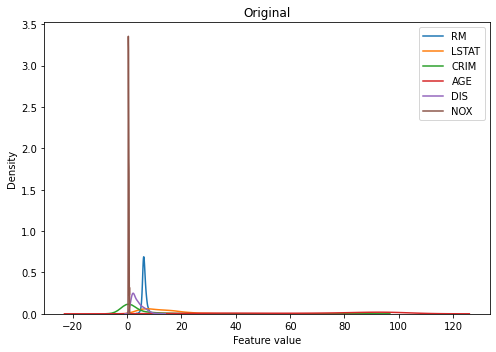

In [3]:
kdeplot(X_train, 'Original')

To quantify the difference in scale between features, we can check some statistic such as mean, standard deviation, minimum, or maximum of observations within each feature. Indeed, they are all very different in their scale and this will be a problem when training certain types of model that requires data to be on the same scale.

In [4]:
X_train.describe().loc[['mean', 'std', 'min', 'max'], :]

,RM,LSTAT,CRIM,AGE,DIS,NOX
mean,6.308427,12.440650,3.358284,68.994068,3.762459,0.556098
std,0.702009,7.078485,8.353223,28.038429,2.067661,0.115601
min,3.561000,1.730000,0.006320,2.900000,1.174200,0.385000
max,8.780000,36.980000,88.976200,100.000000,12.126500,0.871000


<a id=std></a>
## 1. Standardization

One of the most commonly used techniques is standardization, which scales data so different features have the same mean and standard deviation.

**Definition**
- Center data at 0 and set the standard deviation to 1 (variance=1)
    $$
    X' = \frac{X - \mu}{\sigma}
    $$

    where $\mu$ is the mean of the feature and $\sigma$ is the standard deviation of the feature

- The output value is also called Z-score which represents how many standard deviations a value is away from the mean of the feature

**Advantages**
- All features have the same mean and variance, making it easier to compare 
- It is less sensitive to extreme outliers than min-max normalizer
- It preserves the original distribution (If the original distribution is normal distribution, the transformed data will also be normal distribution. Same for skewed distribution)
    
**Limitations**
- It works best when the original distribution is normal distribution (recommended to transform data to normal distribution beforehand)
- It is still affected by outliers as the mean and standard deviation used in the formula is affected by extreme outliers
- There is no fixed bounding range and features have different ranges
- It preserves outliers


Let's see the standardization output of our data shown below. Every feature is centered at around 0 and with the same variance (look at the width of main curves). However, the x limit of each variable differs, especially the ones with extreme outliers such as 'CRIM' have a much longer tail tapping 10. These extreme outliers might work adversely when training a model.

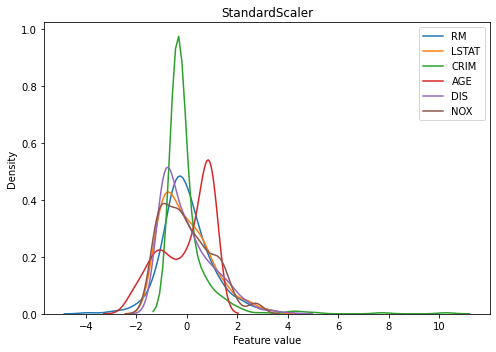

In [5]:
from sklearn.preprocessing import StandardScaler

# fit the scaler to the train set 
scaler_std = StandardScaler().fit(X_train)

# transform data
X_train_scaled_std = scaler_std.transform(X_train)

# put them in dataframe 
X_train_scaled_std = pd.DataFrame(X_train_scaled_std, columns=X_train.columns)

# plot 
kdeplot(X_train_scaled_std, 'StandardScaler')

In [6]:
# summary table shows mean 0 and std 1 for every feature
X_train_scaled_std.describe().loc[['mean', 'std', 'min', 'max'], :]

,RM,LSTAT,CRIM,AGE,DIS,NOX
mean,-5.419394e-16,-3.663109e-16,-1.505387e-17,8.938236e-17,2.258081e-17,-1.655926e-16
std,1.001415e+00,1.001415e+00,1.001415e+00,1.001415e+00,1.001415e+00,1.001415e+00
min,-3.919205e+00,-1.515269e+00,-4.018459e-01,-2.360604e+00,-1.253553e+00,-1.482176e+00
max,3.525700e+00,3.471659e+00,1.026419e+01,1.107402e+00,4.050895e+00,2.727904e+00


<a id=norm></a>
## 2. Normalization

Normalization overcomes standardization's limitation of varying range across features by focusing on limiting the bounding range. The main idea is dividing the values by the maximum or the total range of variables so that every value lies within a fixed range. 

<a id=minmax></a>
### 2.1. Min-max Normalization

**Definition**
- Scale the feature so it has a fixed range such as [0, 1] 
    $$ X' = \frac{X - \text{min}(X)}{\text{max}(X) - \text{min}(X)}$$  


**Advantages**
- Every feature has the same range of [0, 1], removing potentially negative impacts of extreme values 

**Limitations**
- The mean and variance vary between features 
- It may alter the shape of the original distribution 
- It is sensitive to extreme outliers
- The majority of data will be centered within a small range if there are extreme outliers


When applying this to our data, we can see every feature is now within the same range. Note that this graph looks like there are values smaller than 0 and greater than 1, but it is because we are estimating density function from our non-smooth data and the actual values fall within 0 and 1 as you can see in the summary table.

You can also see 'CRIM' has majority of observations at around 0 and quickly fades out after that. This is because of extreme outliers. It would be wise to remove those outliers beforehand so the values are spread more evenly, which will help training.

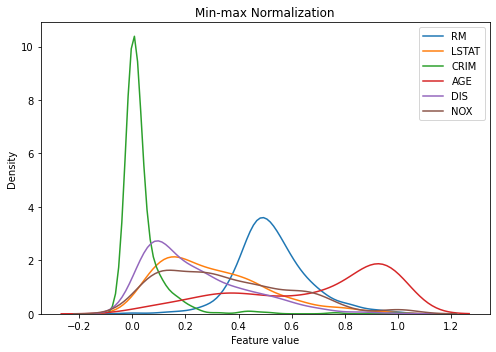

In [7]:
from sklearn.preprocessing import MinMaxScaler

# fit the scaler to the train set 
scaler_minmax = MinMaxScaler().fit(X_train)

# transform data
X_train_scaled_minmax = scaler_minmax.transform(X_train)

# put them in dataframe 
X_train_scaled_minmax = pd.DataFrame(X_train_scaled_minmax, columns=X_train.columns)

# plot
kdeplot(X_train_scaled_minmax, 'Min-max Normalization')

In [8]:
# summary table shows min 0 and max 1 for every feature
X_train_scaled_minmax.describe().loc[['mean', 'std', 'min', 'max'], :]

,RM,LSTAT,CRIM,AGE,DIS,NOX
mean,0.526428,0.303848,0.037675,0.680680,0.236321,0.352054
std,0.134510,0.200808,0.093888,0.288758,0.188788,0.237861
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<a id=maxabs></a>
### 2.2. Maximum absolute normalization

When there are both positive and negative values, it might be wise to keep the sign and only scale the magnitude, so the range becomes roughly [-1, 1]. For instance, if the original feature range is [-50, 50], then we can map it to [-1, 1] by simply dividing the values by the maximum absolute value. This is where max-abs normalizer comes in.

**Definition**
- Scale the feature so it has a fixed range such as [-1, 1] 
    $$X' = \frac{X}{max(\lvert X \lvert)}$$
- This is the same as min-max normalizer if the minimum value is 0 and all values are positive

**Advantages**
- It is handy for features with both positive and negative values as it keeps the sign of values
- It does not shift or center the data, so it does not destroy any sparsity. This technique is often used sparse data.

**Limitations**
- The mean and variance vary between features 
- It may alter the shape of the original distribution 
- It is sensitive to extreme outliers
- The majority of data will be centered within a small range if there are extreme outliers


The graph below is almost the same as the result of min-max normalizer, as all of the features are positive values.

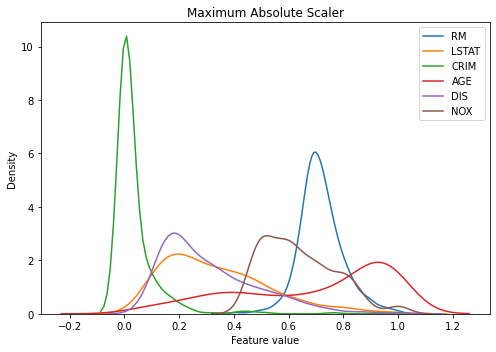

In [9]:
from sklearn.preprocessing import MaxAbsScaler

scaler_maxabs = MaxAbsScaler().fit(X_train)

# transform data
X_train_scaled_maxabs = scaler_maxabs.transform(X_train)

# put them in dataframe 
X_train_scaled_maxabs = pd.DataFrame(X_train_scaled_maxabs, columns=X_train.columns)

# plot
kdeplot(X_train_scaled_maxabs, 'Maximum Absolute Scaler')

<a id=mean></a>
### 2.3. Mean Normalization

Mean normalizer is the same as min-max normalizer but, instead of setting the minimum to 0, it sets the mean to 0.

**Definition**
- Center the feature at 0 and rescale the feature to [-1, 1]

$$ X' = \frac{X-\mu}{\text{max}(X) - \text{min}(X)} $$

**Advantages**
- Every feature has the same range of [-1, 1], removing potentially negative impacts of extreme values 

**Limitations**
- The mean and variance vary between features 
- It may alter the shape of the original distribution 
- It is sensitive to extreme outliers
- The majority of data will be centered within a small range if there are extreme outliers



Unfortunately, there is no specialized function for mean normalization in scikit-learn. Instead, we can use the combination of StandardScaler to remove the mean and RobustScaler to dividing the values by the total value range. 

You can see that now all features are centered around 0 while keeping the min-max range the same across them. This will be definitely handy when applying machine learning models. However, the variance still varies across them, keeping ones with extreme outliers (e.g. 'CRIM') mostly clustered at 0.

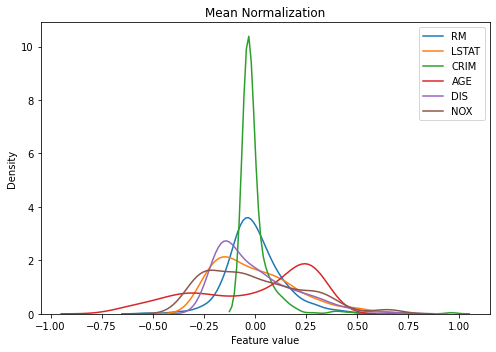

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

# StandardScaler to remove the mean but not scale
scaler_mean = StandardScaler(with_mean=True, with_std=False)

# RobustScaler to divide values by max-min
# Important to keep the quantile range to 0 to 100 (min and max values)
scaler_minmax = RobustScaler(with_centering=False,
                            with_scaling=True,
                            quantile_range=(0, 100))

# fit the scaler to the train set 
scaler_mean.fit(X_train)
scaler_minmax.fit(X_train)

# transform train and test sets
X_train_scaled = scaler_minmax.transform(scaler_mean.transform(X_train))

# put them in dataframe 
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# plot
kdeplot(X_train_scaled, 'Mean Normalization')

<a id=robust></a>
### 2.4. Median-quantile Normalization

Final method is median-quantile normalization, which is also called robust scaler. It is called robust because it is robust to extreme outliers. 


**Definition** 
-  Set the median to 0 and scale to inter-quantile range (range between 25th quantile and 75th quantile)  

$$ X' = \frac{X-\text{median}(X)}{\text{75th quantile}(X) - \text{25th quantile}(X)} $$


**Advantages**
- It is robust to outliers so it is used for data with outliers
- It produces better spread of data for skewed distribution

**Limitations**
- The variance and value range differ between features
- It may not preserve the shape of the original distribution
- It preserves outliers

As you can see in the right graph below, all of the transformed data has better spread and none of the features shows high concentration within a small range unlike other scaling techniques we reviewed so far. However, like the graph on the left, some features with extreme outliers (e.g. 'CRIM') shows a very wide range of values. This method does not set the fixed value range so the extreme values still exist in the data.

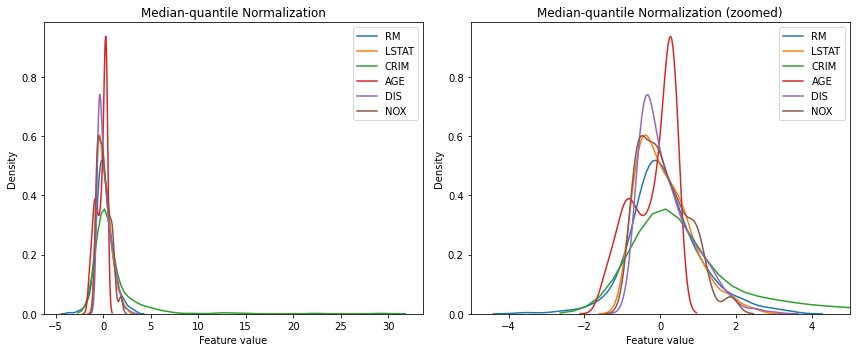

In [11]:
from sklearn.preprocessing import RobustScaler 

scaler_rbs = RobustScaler().fit(X_train)
X_train_scaled_rbs = scaler_rbs.transform(X_train)
X_train_scaled_rbs = pd.DataFrame(X_train_scaled_rbs, columns=X_train.columns)

kdeplot_with_zoom(X_train_scaled_rbs, 'Median-quantile Normalization', [-5, 5])

<a id=summary></a>
# Summary 

So far, we reviewed different methods to scale data. Like mentioned earlier, there is no method that works for every problem. We would need to try different scalers and find the one that works best for a specific application. However, the rule of thumb is, try to use standardization and min-max normalization first and see if other methods or tweaks need to be applied. Some criterion to consider are: 1) does the algorithm prefer data cetered at 0? 2) does the algorithm prefer data to be in a fixed range? Also, it is wise to handle outliers beforehand if necessary.


Here is the summary of the scaling methods reviewed in this post: 

| Category |Standardization | Min-max Normalization | Max-abs Normalization | Mean Normalization | Median-quantile Nromalization|
|--|--|--|--|--|--|
| Concepts | Centering + Unit Variance| Fixed Range |  Fixed Range  | Centering + Fixed Range | Centering + Fixed Quantile Range|
| Definition | Convert data to have zero mean and unit variance | Convert data to be within fixed range (e.g. [0, 1]) |Convert data to be within fixed range (e.g. [-1, 1]) | Convert data to have zero mean and be within fixed range (e.g. [-1, 1]) | Convert data to have zero median and unit interquantile range |
|Sklearn classes| StandardScaler| MinMaxScaler | MaxAbsScaler | StandardScaler + RobustScaler<br><br>* *StandardScaler only for mean removal and RobustScaler for scaling*<br>| RobustScaler|
| Benefits | - Less sensitive to outliers <br>- Easier to compare and learn <br>- Preserves original distribution | - Features in the same range | - Features in the same range <br>- Preserves the sign (good for pos/neg mix) | - Features in the same range| - Least sensitive to outliers <br>- Better spread of values for skewed distribution |
| Limitations |- Range varies between variables <br>- Preserves outliers | - Sensitive to outliers <br>- Mean and variance vary between features | - Sensitive to outliers <br>- Mean and variance vary between features | - Sensitive to outliers <br>-Variance varies between features | - Range varies between features <br>-Variance varies between features |


<a id=ref></a>
# References/Further Reading

- [sciki-learn: Compare the effect of different scalers on data with outliers](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#maxabsscaler)
- [Statistics By Jim: Standardization](https://statisticsbyjim.com/glossary/standardization/)
- [Analytics Vidhya: Feature Scaling for Machine Learning: Understanding the Difference Between Normalization vs. Standardization](https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/)
- [Sebastian Raschka: About Feature Scaling and Normalization](https://sebastianraschka.com/Articles/2014_about_feature_scaling.html#training-a-naive-bayes-classifier)
- [Technical Fridays: Scaling vs Normalization](https://kharshit.github.io/blog/2018/03/23/scaling-vs-normalization)
- [Feature Engineering for Machine Learning](https://www.udemy.com/course/feature-engineering-for-machine-learning/)


# Appendix

## Scaling to vector unit length

Divide each feature vector by either Manhattan distance or Euclidean distance 
* Manhattan distance (L1 norm)
  $$L1(X) = |X_1| + |X_2| + ... + |X_n| $$
* Euclidean distance (L2 norm)
  $$L2(X) = \sqrt{X_1^2 + X_2^2 + ... + X_n^2} $$

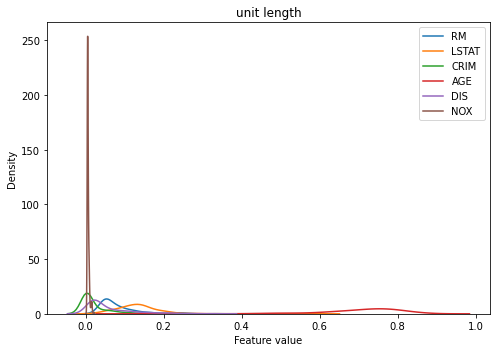

In [12]:
from sklearn.preprocessing import Normalizer

# Manhattan distance
scaler = Normalizer(norm='l1')  # or l2
scaler.fit(X_train) # this does nothing
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns) # actual transform
kdeplot(X_train_scaled, 'unit length')